<h1>TME 04 : Problèmes de Bandits</h1>

<h3>Importations des librairies utilisées</h3>

In [1]:
%pylab inline
import random 

Populating the interactive namespace from numpy and matplotlib


<h3>Chargement des données :</h3>

La fonction getData() charge le fichier CTR.txt dans un tableau, dont la structure est la suivante: <br/>
[(article1, [dim1-1,...,dim1-5], [taux1-1,...taux1-10]),(article2, [dim2-1,...,dim2-5], [taux2-1,...taux2-10]),...]

In [2]:
def getData(filename="CTR.txt"):
    fichier = open(filename)
    l = []
    for line in fichier.readlines() : 
        tmp = line.split(":")
        tmp[2] = tmp[2][:-2]
        l.append((int(tmp[0]),map(float, tmp[1].split(";")),map(float, tmp[2].split(";"))))
    return l

In [3]:
l = getData()

<h3>Définition des 3 baselines :</h3>

<h4>Stratégie Random : A Chaque itération, on choisit n'importe quel annonceur.</h4>

In [4]:
def s_random(l) : 
    choice = []
    choice_cumul = []
    tmp = 0 
    for item in l :
        index = random.randint(0,len(item[2])-1)
        tmp = tmp + item[2][index]
        choice.append((item[0],index))
        choice_cumul.append((item[0],tmp))          
    return choice,choice_cumul

In [5]:
random, random_cum = s_random(l)

<h4>Stratégie StaticBest : A Chaque itération, on choisit l'annonceur avec le meilleur taux de clics cumulés. </h4>

In [6]:
def s_static_best(l) : 
    choice = []
    t_click = [0]*10
    cpt = 0
    choice_cumul = []
    tmp = 0 
    for item in l : 
        t_click= map(add,t_click,item[2])
    
    ind_max = np.argmax(t_click,axis=0)
     
    for item in l:    
        tmp = tmp + item[2][ind_max]
        choice.append((item[0], ind_max))
        choice_cumul.append((item[0],tmp))  
    return choice, choice_cumul

In [7]:
static_best,static_best_cum = s_static_best(l)

<h4>Stratégie Optimale : A Chaque itération, on choisit l'annonceur qui a le meilleur taux de clics à cette itération.</h4> 

In [8]:
def s_opt(l) : 
    choice = []
    cpt = 0
    choice_cumul = []
    tmp = 0 
    for item in l : 
        ind_max = np.argmax(item[2],axis=0)
        tmp = tmp + item[2][ind_max]
        choice.append((item[0], ind_max))
        choice_cumul.append((item[0],tmp)) 
    return choice, choice_cumul

In [9]:
opt,opt_cum = s_opt(l)

La fonction plot_baseline() permet d'afficher la courbe des scores cumulés pour chaque strategie

In [10]:
def plot_baseline(choice_cumul) :
    cumul = []
    x = [c for (c,a) in choice_cumul]
    y = [a for (c,a) in choice_cumul]
    plt.plot(x, y)

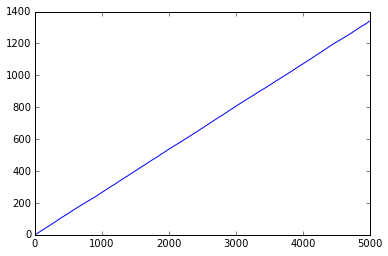

In [11]:
plot_baseline(static_best_cum)

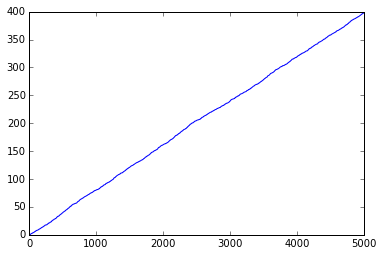

In [12]:
plot_baseline(random_cum)

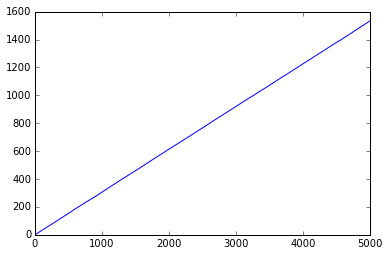

In [13]:
plot_baseline(opt_cum)

La fonction plot_baselines() permet d'afficher toutes les courbes en meme temps. Et nous permet donc de comparer les stratégies.

In [14]:
def plot_baselines(cumuls,names) :
    x = [c for (c,a) in cumuls[0]]
    for i in range(len(cumuls)):
        y = [a for (c,a) in cumuls[i]]
        plt.plot(x, y,label=names[i])
    plt.title('Cumuls')
    plt.legend(loc=0)

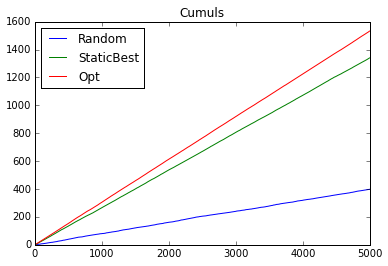

In [15]:
plot_baselines([random_cum, static_best_cum, opt_cum],['Random','StaticBest','Opt'])

<h3>UCB</h3>

In [16]:
def ucb(l) :
    choice = []
    choice_cumul = []
    nb_ad = [1]*len(l[0][2])
    mu_ad = [0]*len(l[0][2])
    chosen_ad = [0]*len(l)
    cumul =[0]*len(l[0][2])
    tmp = 0 
    for (a,_,p) in l : 
        ucb = map(add,mu_ad,[np.sqrt(2*np.log(a+1)/x) for x in nb_ad])
        chosen_ad[a] = np.argmax(ucb)
        idx = chosen_ad[a]
        choice.append((a,idx))
        tmp = tmp + p[idx]
        cumul[idx] += p[idx]
        choice_cumul.append((a,tmp))
        nb_ad[idx] += 1
        mu_ad[idx] = cumul[idx] / nb_ad[idx] 
    return choice , choice_cumul 

In [17]:
ucb,ucb_cum = ucb(l)

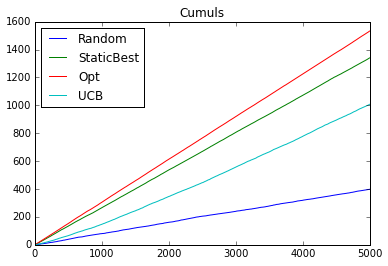

In [18]:
plot_baselines([random_cum, static_best_cum, opt_cum,ucb_cum],['Random','StaticBest','Opt','UCB'])

<h3>LinUCB</h3>

In [19]:
def vector_dot(v,u) :
    return sum(v_i*u_i for v_i,u_i in zip(v,u)) 

In [53]:
from collections import defaultdict
def LinUcb(l,alpha=0.5) :
    choice = []
    choice_cumul = []
    tmp = 0 
    a_dict = defaultdict(np.ndarray)
    b_dict = defaultdict(dict)
    theta  = defaultdict(dict)
    p  = defaultdict(dict)
    for (t,x,at) in l :
        d =len(x)
        for i,a in enumerate(at) :
            #if a not in a_dict.keys() :
            a_dict[i] = np.eye(d)
            b_dict[i] = [0]*d
            inv = np.linalg.inv(a_dict[i])
            theta[i] = vector_dot(inv,b_dict[i])
            p[i] = vector_dot(theta[i],x) + alpha * np.sqrt(vector_dot(x,(vector_dot(inv,x))))
        index = np.random.choice(np.where(p.values() == max(p.values()))[0])
        choice.append((t,index))
        tmp = tmp + at[index]
        choice_cumul.append((t,tmp))
        a_dict[index] += vector_dot(x,x)
        b_dict[index] += np.array(x)*at[index]
    return choice , choice_cumul

In [54]:
ucbLin,ucbLin_cum = LinUcb(l)

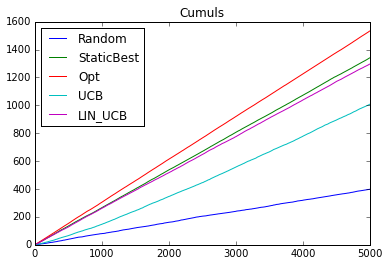

In [55]:
plot_baselines([random_cum, static_best_cum, opt_cum,ucb_cum,ucbLin_cum],['Random','StaticBest','Opt','UCB','LIN_UCB'])